In [1]:
import sys

sys.path.append('./source/')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, stats
import matplotlib.cm as cm
from numpy import fft
from scipy import interpolate as intp
import importlib


from source import plots
from source import prob_dists as pd
from utils import read_param_file, update_params


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
param_file = './source/n-1.params'
params = read_param_file(param_file)
p = params
p

{'R_G': 220,
 'd_solar': 8.5,
 'psi': 40,
 'M_min': 0.01,
 'M_max': 10000000000.0,
 'fwimp': 1.0,
 'mean_params': {'a': 77.4, 'b': 0.87, 'c': -0.23},
 'nside': 128,
 'area_fermi': 2000.0,
 'n': 0,
 'log_flux_min': -15,
 'log_flux_max': -5,
 'N': 1000,
 'log_k_min': -3,
 'log_k_max': 6,
 'N_k': 250000,
 'psh_log_f_min': -5,
 'psh_log_f_max': -3.5,
 'N_psh': 500,
 'omega_pixel': 6.391586616190171e-05,
 'exposure': 5570.423008216337,
 'iso_flux_bg': 0.0008939106670451649,
 'gal_flux_bg_file': './output/gal_flux_bg.npy'}

In [4]:
p = update_params(param_file, p, 'exposure', 5 * 14000 / (4 * np.pi))

In [5]:
with np.load('./output/n-1_pshfunc.npz') as f:
    psi = f['psi']
    fluxes = f['flux']
    psh2d = f['psh']

In [6]:
psh2d[psh2d < 0] = 0
pshfunc2d = intp.interp2d(psi, fluxes, np.nan_to_num(psh2d), bounds_error=False, fill_value=0)
fluxes = fluxes[150:-50]
np.log10(fluxes[-1])

-2.8032128514056227

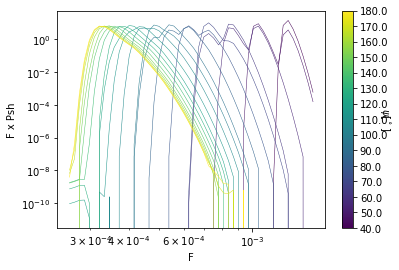

In [7]:
numnum = 20
psis = np.linspace(40, 180, num=numnum)
colors = cm.viridis(np.linspace(0, 1, num=numnum))

fig, ax = plt.subplots()

psh_vals_over_psi = []
fxs = fluxes
for psi, col in zip(psis, colors):
    ax.plot(fxs, fxs * pshfunc2d(psi, fxs).flatten(), label=rf"{psi}$^\circ$", color=col, lw=0.5)
#     print(np.trapz(fxs * pshfunc2d(psi, fxs).flatten(), fxs))
   
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('F')
ax.set_ylabel('F x Psh')
cbarlabs = np.arange(min(psis), max(psis)+1, step=10)
cbar = fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ticks=np.linspace(0, 1, num=len(cbarlabs)))
cbar.set_label(r'$\psi$[$^\circ$]', rotation=270)
cbar.ax.set_yticklabels(cbarlabs);

In [8]:
pshfunc2d(psis, fluxes).shape, psis.shape, fluxes.shape

((50, 20), (20,), (50,))

In [9]:
counts = np.arange(0, 50)
exposure = 1 * 14000 * 0.2/0.5
psi = 40

In [10]:
from scipy.stats import poisson
print(poisson.pmf(counts[:, np.newaxis], exposure * fluxes).shape, pshfunc2d(40, fluxes).flatten().shape)

pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)
# func = pshfunc2d(40, fluxes).flatten() * poisson.pmf(2, exposure * fluxes)
pcvals

(50, 50) (50,)


array([6.76674064e-04, 4.92236603e-03, 1.79161481e-02, 4.35046749e-02,
       7.92877135e-02, 1.15688200e-01, 1.40773271e-01, 1.46939976e-01,
       1.34310393e-01, 1.09213233e-01, 7.99905795e-02, 5.33055400e-02,
       3.25902259e-02, 1.84084887e-02, 9.66384913e-03, 4.73928975e-03,
       2.18097531e-03, 9.45521716e-04, 3.87516663e-04, 1.50612058e-04,
       5.56665851e-05, 1.96151980e-05, 6.60467028e-06, 2.12951024e-06,
       6.58737295e-07, 1.95846512e-07, 5.60530050e-08, 1.54674171e-08,
       4.12081022e-09, 1.06135839e-09, 2.64598710e-10, 6.39230942e-11,
       1.49809804e-11, 3.40938196e-12, 7.54188234e-13, 1.62310078e-13,
       3.40130073e-14, 6.94594722e-15, 1.38337635e-15, 2.68900079e-16,
       5.10490319e-17, 9.47153614e-18, 1.71856911e-18, 3.05135302e-19,
       5.30457523e-20, 9.03409405e-21, 1.50809078e-21, 2.46889573e-22,
       3.96574548e-23, 6.25316037e-24])

In [11]:
print(exposure*np.trapz(fluxes * pshfunc2d(40, fluxes).flatten(), fluxes))
pp = poisson.pmf(counts, exposure*np.trapz(fluxes * pshfunc2d(40, fluxes).flatten(), fluxes))

7.283073945753144


Text(0, 0.5, 'P(C) for 40 deg, n=0')

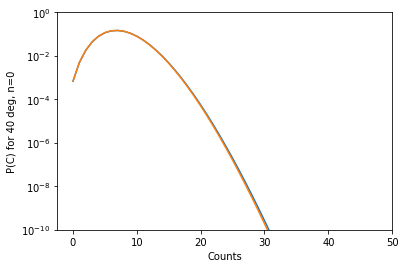

In [12]:
plt.plot(counts, pcvals)
plt.plot(counts, pp)
ax = plt.gca()

ax.set_yscale('log')
ax.set_ylim(top=1, bottom=1e-10)
ax.set_xlim(right=50)
ax.set_xlabel('Counts')
ax.set_ylabel('P(C) for 40 deg, n=0')

In [13]:
import healpy

In [14]:
nside = p['nside']
npix = healpy.nside2npix(nside)
pixel_counts = np.ones(npix) * healpy.pixelfunc.UNSEEN
print(npix)

196608


In [15]:
lon, lat = healpy.pix2ang(nside, range(npix), lonlat=True)
ang_dists = np.rad2deg(np.arccos(np.cos(np.deg2rad(lon)) * np.cos(np.deg2rad(lat))))
ang_dists, lon, lat

(array([89.74156502, 90.25843498, 90.25843498, ..., 90.25843498,
        90.25843498, 89.74156502]),
 array([ 45., 135., 225., ..., 135., 225., 315.]),
 array([ 89.6345165,  89.6345165,  89.6345165, ..., -89.6345165,
        -89.6345165, -89.6345165]))

In [16]:
lon, lat, max(ang_dists), min(ang_dists)

(array([ 45., 135., 225., ..., 135., 225., 315.]),
 array([ 89.6345165,  89.6345165,  89.6345165, ..., -89.6345165,
        -89.6345165, -89.6345165]),
 179.70158313251247,
 0.2984168674875423)

In [17]:
print(healpy.nside2pixarea(128, degrees=True))

0.2098234113027917


In [18]:
psis = np.linspace(40, 180, num=50)
pc_psi = np.array([np.trapz(pshfunc2d(abs(psi), fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1) for psi in psis])
pc_of_psi = intp.interp1d(psis, pc_psi, axis=0)

In [19]:
good_indices = (abs(lat) >= 40)

In [20]:
# subsample = ang_dists[good_indices]
# print(len(subsample))
# sub_counts = np.zeros(len(subsample))
# for i, psi in enumerate(subsample):
#     if i % 10000 == 0:
#         print(i, '/', len(subsample))
# #     print(psi)
#     pcvals = pc_of_psi(abs(psi))
#     sub_counts[i] = np.random.choice(np.arange(len(pcvals)), size=1, p=pcvals/np.sum(pcvals))
    
# pixel_counts[good_indices] = sub_counts
# pixel_counts_pc = pixel_counts[:]

In [21]:
# nreduce = 64
# healpy.mollview(healpy.pixelfunc.ud_grade(healpy.pixelfunc.ma(pixel_counts_pc), nreduce, pess=True, power=-2), cmap=cm.jet, title="Mollview P(C)")
# print(healpy.nside2pixarea(nreduce, degrees=True))
# np.mean(pixel_counts_pc[good_indices]), np.sum(pixel_counts_pc[good_indices])

In [22]:
# lsub = len(subsample)
# pixel_counts_poisson = np.ones(npix) * healpy.pixelfunc.UNSEEN
# sub_counts = np.zeros(lsub)
# for i, psi in enumerate(subsample):
#     if i % 10000 == 0:
#         print(i, '/', lsub)
# #     print(psi)
#     sub_counts[i] = stats.poisson.rvs(exposure*np.trapz(fluxes * pshfunc2d(psi, fluxes).flatten(), fluxes))
# #     if sub_counts[i] > 5: 
# #         print(sub_counts[i])
    
# pixel_counts_poisson[good_indices] = sub_counts


In [23]:
# healpy.mollview(healpy.pixelfunc.ud_grade(healpy.pixelfunc.ma(pixel_counts_poisson), nreduce, pess=True, power=-2), cmap=cm.jet, title="Poisson", max=50)
# np.mean(pixel_counts_poisson[good_indices]), np.sum(pixel_counts_poisson[good_indices])

In [24]:
# nreduce = 64
# # pixel_counts = pd.generate_skymap_sample_pc(p, pc_of_psi, save_output=True, with_bg=True)
# healpy.mollview(healpy.pixelfunc.ud_grade(healpy.pixelfunc.ma(pixel_counts), nreduce, pess=True, power=-2), cmap=cm.jet, title="Mollview P(C)")
# healpy.nside2pixarea(nreduce, degrees=True), np.mean(pixel_counts[good_indices]), np.sum(pixel_counts[good_indices])

In [25]:
importlib.reload(pd)
with np.load('./output/n-1_pshfunc.npz') as f:
    psi = f['psi']
    fluxes = f['flux']
    psh2d = f['psh']

# restrict to valid range of flux calculation
low_lim = 150
valid_lim = -50
fluxes = fluxes[low_lim:valid_lim]
psh2d = psh2d[low_lim:valid_lim]

# generate data with different fwimp
f = p['fwimp']
p['exposure'] *= 1

# get psh data as function of psi and flux
counts = np.arange(0, 1000)
psh2d[psh2d < 0] = 0
pshfunc2d = intp.interp2d(psi, fluxes, np.nan_to_num(psh2d), bounds_error=False, fill_value=0)

# make the simulated skymap
psis = np.linspace(40, 180, num=50)
pc_psi = np.array([1/f * np.trapz(pshfunc2d(abs(psi), fluxes).flatten() * stats.poisson.pmf(counts[:, np.newaxis], p['exposure'] * f * fluxes), f * fluxes, axis=-1) for psi in psis])
pc_of_psi = intp.interp1d(psis, pc_psi, axis=0)
# print(psh2d)

background = True
subcounts, ang_dists, bg_count = pd.generate_skymap_sample_pc(p, pc_of_psi, return_subcounts=True, save_output=True, with_bg=background)
print(subcounts)

# get psh for the angles we are considering 
psh = pshfunc2d(np.abs(ang_dists), fluxes)
psh /= np.trapz(psh, fluxes, axis=0)
# print(ang_dists.shape)

saved in ./output/n0_skymap_87323.npy
[7. 9. 9. ... 8. 9. 9.]


0.8392936452111668


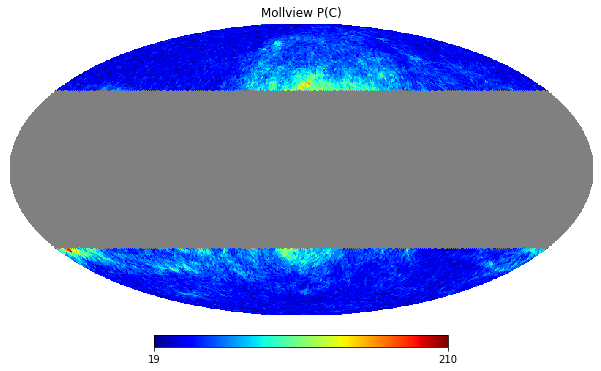

In [28]:
pixel_counts[good_indices] = subcounts
nreduce = 64
healpy.mollview(healpy.pixelfunc.ud_grade(healpy.pixelfunc.ma(pixel_counts), nreduce, pess=True, power=-2), cmap=cm.jet, title="Mollview P(C)")
print(healpy.nside2pixarea(nreduce, degrees=True))
# np.mean(pixel_counts_pc[good_indices]), np.sum(pixel_counts_pc[good_indices])

In [ ]:
importlib.reload(pd)
import time
start_time = time.time()
num_search = 50
f = p['fwimp']
fwimp_search = (np.log10(f)-3, np.log10(f)+2, num_search)

# backgrounds
gal_bg = np.load(p['gal_flux_bg_file'])[good_indices] * p['exposure']
iso_bg = p['iso_flux_bg'] * p['exposure']
bg_count = gal_bg + iso_bg
# bg_count = np.array([0])

print(bg_count[:5], p['exposure'], bg_count.max())
# use different subcoutns?
# subcounts = np.load('./output/n0_skymap_10336.npy')[good_indices]
# subcounts = np.load('./output/n0_skymap_23454.npy')[good_indices]

counts = np.arange(0, max(subcounts)+1)

S, fwimps = pd.likelihood(p, psh, subcounts.astype(np.int64), fluxes, counts, fwimp_limits=fwimp_search, bg_count=bg_count)
                                                                                                                                              
print('time per eval', (time.time() - start_time)/num_search)

In [ ]:
fig, axs = plt.subplots()
axs.plot(fwimps, np.exp(-0.5*(S - S.min())), color='xkcd:tangerine', label='P(C)')
axs.set_xlabel(r'f$_{SUSY}$', fontsize=20)
axs.set_xscale('log')
# axs.set_ylabel(r'$\mathcal{S}-\mathcal{S}_{min}$', fontsize=20)
axs.set_ylabel(r'$\mathcal{L}$')
axs.set_ylim(bottom=0, top=1)
print(p['fwimp'],'fwimp:', fwimps[S.argmin()], '\t S:', S.min())
# print('max L:', np.exp(-0.5*S.min()))

In [ ]:
np.savez('./output/n-1_S.npz', S=S, fwimps=fwimps)

In [ ]:
importlib.reload(pd)
Spoi, fwimpspoi = pd.poisson_likelihood(p, psh, subcounts.astype(np.int16), fluxes, counts, fwimp_limits=fwimp_search)

In [ ]:
axs.plot(fwimpspoi, np.exp(-0.5*(Spoi-Spoi.min())), color='xkcd:wine', label='Poisson')
axs.legend()
axs.set_yscale('linear')
print('P(C) min of -2 ln L:', S.min())
print('Poisson min of -2 ln L:', Spoi.min())
fig

In [ ]:
print(fwimps[Spoi.argmin()], Spoi.min())
print(np.log10(np.e)*1500)

In [ ]:
a = np.reshape(np.arange(9), (3, 3))
print(a)
a[np.array([[1, 0], [1, 2] , [2, 1]])]

In [ ]:
import scipy.stats as st

class my_pdf(st.rv_continuous):
    def _pdf(self, x):
        return custom_pdf(x)
    
    def _cdf(self, x):
        return custom_cdf(x)
    
    def _ppf(self, x):
        return custom_ppf(x)

In [ ]:
psi = 50
custom_pdf = lambda x: pshfunc2d(psi, x).flatten()

norm = np.trapz(pshfunc2d(psi, fluxes).flatten(), fluxes)
discrete_cdf = integrate.cumtrapz(pshfunc2d(psi, fluxes).flatten(), fluxes, initial=0)
custom_cdf = intp.interp1d(fluxes, discrete_cdf, fill_value=0, bounds_error=False)

custom_ppf = intp.interp1d(discrete_cdf, fluxes, fill_value=0, bounds_error=False)

func50 = my_pdf(a=fluxes.min(), b=fluxes.max(), name='my_pdf')

In [ ]:
# pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)

def pc(psi, counts_max=15):
    counts = np.arange(0, counts_max + 1)
    
    pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)
    custom_pdf = intp.interp1d(counts, pcvals, fill_value=0, bounds_error=False)
    
    discrete_cdf = integrate.cumtrapz(pcvals, counts, initial=0)
    custom_cdf = intp.interp1d(counts, discrete_cdf, fill_value=0, bounds_error=False)

    custom_ppf = intp.interp1d(discrete_cdf, counts, fill_value=0, bounds_error=False)
    
    return my_pdf(a=fluxes.min(), b=fluxes.max(), name='my_pdf')

In [ ]:
pc(50).rvs(size=10)

In [ ]:
psi = 40
pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)
pp = poisson.pmf(counts, exposure*fluxes[np.argmax(pshfunc2d(psi, fluxes))])

print(np.sum(pcvals/np.sum(pcvals)))
plt.plot(counts, pcvals)
plt.plot(counts, pp)
plt.hist(np.random.choice(np.arange(len(pcvals)), size=100000, p=pcvals/np.sum(pcvals)))

ax = plt.gca()
ax.set_yscale('log')
# ax.set_ylim(top=1, bottom=1e-20)
ax.set_xlabel('Counts')
# ax.set_xscale('log')
ax.set_ylabel('P(C) for 40 deg, n=0')

In [ ]:
fig, ax = plt.subplots()
bins = np.logspace(np.log10(fluxes.min()), np.log10(fluxes.max()), num=50)
ax.hist(func50.rvs(size=100000), bins=bins)
ax.plot(fxs, fxs * pshfunc2d(psi, fxs).flatten(), label=rf"{psi}$^\circ$")
ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
for i, latt in enumerate(lat):
    if latt < 40:
        pixel_counts[i] = 0
    else:
        